**VERSION** LSTM Multistep Multivariate  v1.2 6-Dec-2019.
Prototype date: 17-Dec-2019
***
**PROBLEM FRAME**

*'Build a model that can forecast **4** values ahead'*

**ACKNOWLEDGEMENT**

*This notebook is heavily inspired by [Jason Brownlee](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)*.

*Special thanks to Anand and Howard.* 





In [0]:
# Run this before everything
pip install --upgrade tensorflow

In [0]:
from google.colab import drive
import pandas as pd
from pandas import read_csv, to_datetime
import numpy as np
from numpy import array,hstack
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = 10, 5
import seaborn as sns
from tensorflow.keras.models import load_model
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt

# **1. Import Data**

*a*) Import the dataset 

In [0]:
drive.mount('/content/gdrive')

In [3]:
cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [0]:
ls

In [0]:
#Import the dataset
dataset = read_csv(r'UTSusageAutOct2019.csv', header = 0, index_col = ['ReadingDateTime'] ) #parse_dates = [['Date', 'Time']]
print(dataset.columns)
needed_columns = [
       'kWh'  , 'kW'  , 'kVa'  , 'Power Factor' , 
       'kWh.1', 'kW.1', 'kVa.1', 'Power Factor.1',
       'kWh.2', 'kW.2', 'kVa.2', 'Power Factor.2',
       'kWh.3', 'kW.3', 'kVa.3', 'Power Factor.3',
       'kWh.4', 'kW.4', 'kVa.4', 'Power Factor.4',
       'DemandKva']
dataset = dataset[needed_columns]
print(dataset['DemandKva'][0:5])
kva_s  = MinMaxScaler()
kva1_s = MinMaxScaler()
kva2_s = MinMaxScaler()
kva3_s = MinMaxScaler()
kva4_s = MinMaxScaler()
demand_s = MinMaxScaler()

dataset['kVa'] = kva_s.fit_transform(dataset[['kVa']])
dataset['kVa.1'] = kva1_s.fit_transform(dataset[['kVa.1']])
dataset['kVa.2'] = kva2_s.fit_transform(dataset[['kVa.2']])
dataset['kVa.3'] = kva3_s.fit_transform(dataset[['kVa.3']])
dataset['kVa.4'] = kva4_s.fit_transform(dataset[['kVa.4']])
dataset['DemandKva'] = demand_s.fit_transform(dataset[['DemandKva']])
dataset.head()

# **2. Visualisation**

**b) Visualise**

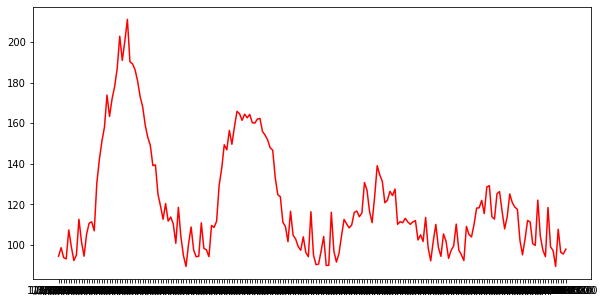

In [0]:
plt.plot(dataset.DemandKva[:200], color = 'r')
#plt.plot(dataset1.DemandKva[:200], color = 'b')

plt.show()
#print("Correlation: " + str(dataset['DemandKva'].corr(dataset1['DemandKva'])))

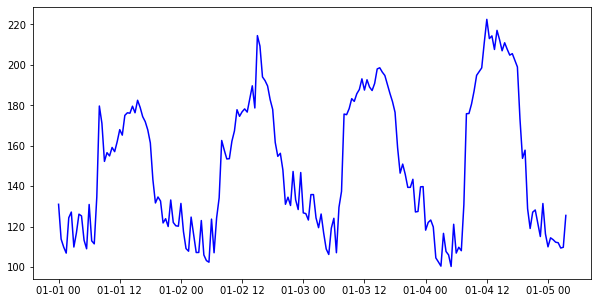

In [0]:
plt.plot(dataset1.DemandKva[:200], color = 'b')

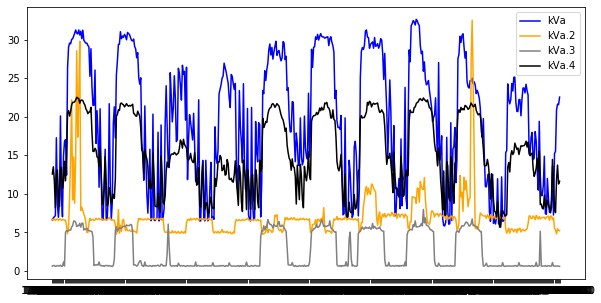

In [0]:
plt.plot(dataset['kVa'][:500]   , color = 'blue', label = 'kVa')
#
plt.plot(dataset['kVa.2'][:500] , color = 'orange', label = 'kVa.2' )
plt.plot(dataset['kVa.3'][:500] , color = 'grey', label = 'kVa.3')
plt.plot(dataset['kVa.4'][:500] , color = 'black', label = 'kVa.4')
plt.legend()

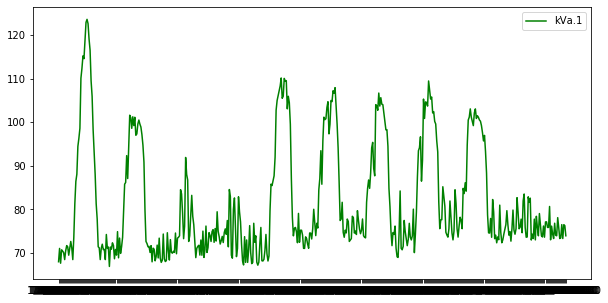

In [0]:
plt.plot(dataset['kVa.1'][:500] , color = 'green', label = 'kVa.1')
plt.legend()

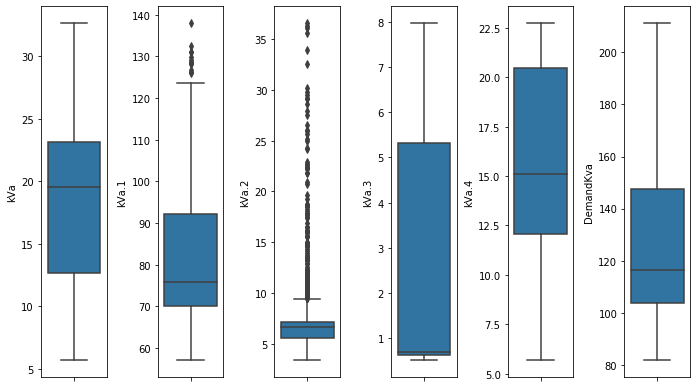

In [0]:
f, axes = plt.subplots(1, 6, sharey = False, figsize=(10, 6) )
f.tight_layout(pad = 2) 
sns.boxplot(x="kVa"      , data= dataset, ax=axes[0], orient = "v")
sns.boxplot(x="kVa.1"    , data= dataset, ax=axes[1], orient = "v")
sns.boxplot(x="kVa.2"    , data= dataset, ax=axes[2], orient = "v")
sns.boxplot(x="kVa.3"    , data= dataset, ax=axes[3], orient = "v")
sns.boxplot(x="kVa.4"    , data= dataset, ax=axes[4], orient = "v")
sns.boxplot(x="DemandKva", data= dataset, ax=axes[5], orient = "v")

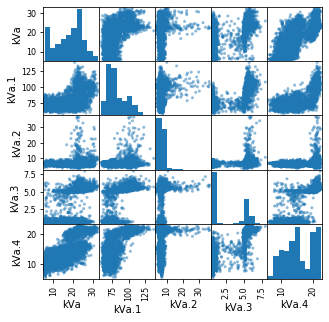

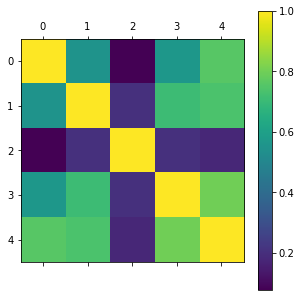

In [0]:
pd.plotting.scatter_matrix(dataset[['kVa','kVa.1','kVa.2','kVa.3','kVa.4',]], figsize=(5,5))
plt.matshow(dataset[['kVa','kVa.1','kVa.2','kVa.3','kVa.4',]].corr())
plt.colorbar()
plt.show()

From the visualisation above, it can be concluded that machine kVa.1 contribute the most to the total demand of electricity, while the opposite is true for machine kVa.3. 
About the frequency, machine kVa, kVa.1, kVa.4 are widely used throughtout the week. Noticeably, kVa and kVa.4 are highly related in terms of use frequency.

In [0]:
# Dickey-Fuller test
# H0: The 'Peak' is not stationary.
result = adfuller(dataset['DemandKva'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
print("=> We reject the Null Hypothesis. The 'Peak' is stationary.")

ADF Statistic: -7.644662
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
=> We reject the Null Hypothesis. The 'Peak' is stationary.


# **3. Model**

a) Split

In [0]:
def split_dataset(dataset, test_ratio = 0.2):
  ##########################################
  # Split the dataset into train, test set #
  ##########################################
  train_size = int(len(dataset) * (1-test_ratio))
  train = dataset[:train_size]
  test = dataset[train_size:]
  return train, test

def split_sequences(sequences, n_steps_in, n_steps_out):
  ##############################################
  # split a multivariate sequence into samples #
  ##############################################
  X, y = list(), list()
  for i in range(len(sequences)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out-1 # check if we are beyond the dataset 
    if out_end_ix > len(sequences):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1] 
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)




```
needed_columns = [
       'kWh'  , 'kW'  , 'kVa'  , 'Power Factor' , 
       'kWh.1', 'kW.1', 'kVa.1', 'Power Factor.1',
       'kWh.2', 'kW.2', 'kVa.2', 'Power Factor.2',
       'kWh.3', 'kW.3', 'kVa.3', 'Power Factor.3',
       'kWh.4', 'kW.4', 'kVa.4', 'Power Factor.4',
       'DemandKva']
```

In [0]:
#Preprocess the data
output = array(dataset['DemandKva']).reshape((len(dataset)), 1)
var1 = array(dataset['kVa']).reshape((len(dataset)), 1)
var2 = array(dataset['kVa.1']).reshape((len(dataset)), 1)
var3 = array(dataset['kVa.2']).reshape((len(dataset)), 1)
var4 = array(dataset['kVa.3']).reshape((len(dataset)), 1)
var5 = array(dataset['kVa.4']).reshape((len(dataset)), 1)
#var6 = array(dataset['']).reshape((len(dataset)), 1)
#var7 = array(dataset['']).reshape((len(dataset)), 1)
#var8 = array(dataset['']).reshape((len(dataset)), 1)
#var9 = array(dataset['']).reshape((len(dataset)), 1)

input_dataset =  hstack((var1, var2, var3, var4, var5, output))

In [8]:
print(output)
print(input_dataset)

[[0.09895793]
 [0.13130066]
 [0.09347742]
 ...
 [0.29756851]
 [0.35970668]
 [0.32196063]]
[[0.03450835 0.13539222 0.09975889 0.01474531 0.40421793 0.09895793]
 [0.04378479 0.1730698  0.09674503 0.0227882  0.45869947 0.13130066]
 [0.04935065 0.13119209 0.10126582 0.02412869 0.35207967 0.09347742]
 ...
 [0.70834879 0.14947498 0.11030741 0.0308311  0.75336848 0.29756851]
 [0.54137291 0.30772082 0.11603376 0.01474531 0.73403632 0.35970668]
 [0.49499072 0.28869673 0.11181435 0.02412869 0.61511424 0.32196063]]


In [23]:
n_steps_in= 5
n_steps_out = 5
# split dataset into train and test set
train, test = split_dataset(input_dataset, 0.2)
# split into samples
X_train, y_train = split_sequences(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequences(test, n_steps_in, n_steps_out)
#y_train = demand_s.inverse_transform(y_train)
#y_test = demand_s.inverse_transform(y_test)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train[0])
print(y_train[0])

(2872, 5, 5)
(2872, 5)
(712, 5, 5)
(712, 5)
[[0.03450835 0.13539222 0.09975889 0.01474531 0.40421793]
 [0.04378479 0.1730698  0.09674503 0.0227882  0.45869947]
 [0.04935065 0.13119209 0.10126582 0.02412869 0.35207967]
 [0.05454545 0.16911674 0.0952381  0.00938338 0.14762742]
 [0.4296846  0.16553428 0.09885473 0.01474531 0.39660223]]
[0.19876496 0.13577769 0.0825164  0.10343497 0.23936704]


c) Train LSTM model

In [24]:
import tensorflow
print(tensorflow.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

2.1.0


Train on 2297 samples, validate on 575 samples
Epoch 1/100
2297/2297 - 1s - loss: 0.0281 - val_loss: 0.0132
Epoch 2/100
2297/2297 - 1s - loss: 0.0114 - val_loss: 0.0126
Epoch 3/100
2297/2297 - 1s - loss: 0.0103 - val_loss: 0.0118
Epoch 4/100
2297/2297 - 1s - loss: 0.0092 - val_loss: 0.0109
Epoch 5/100
2297/2297 - 1s - loss: 0.0081 - val_loss: 0.0096
Epoch 6/100
2297/2297 - 1s - loss: 0.0074 - val_loss: 0.0086
Epoch 7/100
2297/2297 - 1s - loss: 0.0068 - val_loss: 0.0079
Epoch 8/100
2297/2297 - 1s - loss: 0.0064 - val_loss: 0.0075
Epoch 9/100
2297/2297 - 1s - loss: 0.0060 - val_loss: 0.0070
Epoch 10/100
2297/2297 - 1s - loss: 0.0057 - val_loss: 0.0067
Epoch 11/100
2297/2297 - 1s - loss: 0.0058 - val_loss: 0.0068
Epoch 12/100
2297/2297 - 1s - loss: 0.0054 - val_loss: 0.0063
Epoch 13/100
2297/2297 - 1s - loss: 0.0052 - val_loss: 0.0062
Epoch 14/100
2297/2297 - 1s - loss: 0.0051 - val_loss: 0.0060
Epoch 15/100
2297/2297 - 1s - loss: 0.0050 - val_loss: 0.0059
Epoch 16/100
2297/2297 - 1s - lo

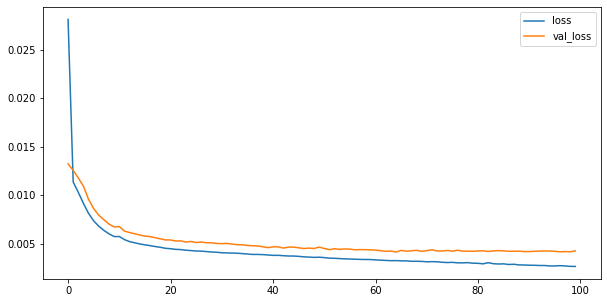

In [30]:
def build_model(X_train, y_train, X_test, y_test, n_steps_in, n_steps_out, epochs, verbose): 
  ## Build an LSTM model ##
    # Define model
    model = Sequential()
    model.add(LSTM(150, activation='relu', return_sequences= False, input_shape=(n_steps_in, X_train.shape[2])))
    model.add(Dropout(0.001))
    #model.add(LSTM(100, activation='relu', return_sequences= False))
    #model.add(Dense(5))
    #model.add(LSTM(26, activation= 'relu'))
    #model.add(Dropout(0.01))
    model.add(Dense(n_steps_out))
    
    # Train Model
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, validation_split= 0.2, shuffle = False)
    
    # Visualise Epoch
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()

    return model, history

model, history = build_model(X_train, y_train, X_test, y_test, n_steps_in = n_steps_in, n_steps_out = n_steps_out, epochs = 100, verbose = 2)

c) Prediction

In [0]:
def RMSE(model, X_test, y_test, n_steps_out):
  y_hat = demand_s.inverse_transform(model.predict(X_test))
  
  RMSE = np.sqrt(mean_squared_error(demand_s.inverse_transform(y_test), y_hat, multioutput='raw_values'))
  mean_RMSE = sum(RMSE)/ n_steps_out
    
  return y_hat, RMSE, mean_RMSE

In [37]:
#####################
y_hat_train, RMSE_train, mean_RMSE_train = RMSE(model, X_train, y_train, n_steps_out)
print("Train RMSE: " + str(RMSE_train))
print("Mean Train RMSE: "+ str(mean_RMSE_train))
#####################
y_hat, RMSE_test, mean_RMSE_test = RMSE(model, X_test, y_test, n_steps_out)
print("Test RMSE: " + str(RMSE_test))
print("Mean Test RMSE: " + str(mean_RMSE_test))

Train RMSE: [1.15153672 6.49693959 7.60448462 8.37722341 9.33973553]
Mean Train RMSE: 6.593983974269167
Test RMSE: [ 1.40295271  8.76884742  9.95174778 10.7003437  11.47485891]
Mean Test RMSE: 8.459750101651693


d) Save the model

In [0]:
model.save("./LSTMmul/LSTM__________.h5")